# 3D Keypoint Social Interaction Analysis

**Author:** Mir Qi  
**Date:** October 2024  
**Purpose:** Analyze 3D keypoint tracking data from s-DANNCE for multi-animal social behavior experiments. 

## Overview

This notebook demonstrates analysis of 3D pose tracking data merged/aligned with calcium imaging (miniscope) recordings. The pipeline includes:

1. **Data Loading**: Merge s-DANNCE predictions with miniscope and COM data
2. **Distance Analysis**: Compute inter-animal distances and proximity events
3. **Motion Analysis**: Calculate velocities, speeds, and approach behaviors
4. **Visualization**: Plot skeletons, trajectories, and interaction heatmaps
5. **Event Detection**: Identify social interaction incidents and approach sequences

---

## Setup & Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append(os.path.abspath('../'))

# Import data loading utilities
from utlis.sync_utlis.general_loader import load_flat_with_frame_map, merge_pred_with_miniscope
from utlis.sync_utlis.general_loader_viz import plot_two_coms_from_pred_df

# Import our analysis functions
from utlis.present_vis.keypoint_3d_analysis import (
    compute_com_distance,
    compute_motion_direction,
    find_approach_success,
    get_proximity_rows_by_com,
    point_distance,
    snout_to,
    plot_skeleton_frames,
    plot_incidents_3d_grid,
    plot_ca_heatmap_and_distance,
    plot_incident_windows_newset,
    visualize_frames_allcams,
    KP, MOUSE22_EDGES
)

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)

print("✓ Imports complete")


✓ Imports complete


---
## 1. Load & Merge Data

Load s-DANNCE predictions and merge with miniscope calcium imaging data.

In [2]:
# Configuration
OCT3V1_BASE = "/data/big_rim/rsync_dcc_sum/Oct3V1"
REC_PATH = os.path.join(
    OCT3V1_BASE,
    "2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30"
)

# Miniscope analysis parameters
NC_KEY = 'wnd1500_stp700_max25_diff3.5_pnr1.1'
DANNCE_FOLDER = 'SDANNCE/predict01'

print(f"Recording path: {REC_PATH}")
print(f"Loading data...")

Recording path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Loading data...


In [3]:
# Merge all data streams
merged = merge_pred_with_miniscope(
    rec_path=REC_PATH,
    nc_key=NC_KEY,
    dannce_folder=DANNCE_FOLDER,
    com_folder=None,  # Will use COM from DANNCE
    save_h5=False,
    save_csv=False,
)

print(f"\n✓ Data loaded successfully")
print(f"Shape: {merged.shape}")
print(f"Time range: {merged.index.min()} to {merged.index.max()} ms")
print(f"Duration: {(merged.index.max() - merged.index.min()) / 1000 / 60:.1f} minutes")


✓ Data loaded successfully
Shape: (12700, 273)
Time range: -5 to 426776 ms
Duration: 7.1 minutes


In [4]:
# Display data structure
print("\nColumn categories:")
com_cols = [c for c in merged.columns if 'com' in c]
kp_cols = [c for c in merged.columns if 'kp' in c and '_a1' in c][:10]
ca_cols = [c for c in merged.columns if 'dF_F' in c][:5]

print(f"  COM columns: {len(com_cols)} (e.g., {com_cols[:3]})")
print(f"  Keypoint columns: {len([c for c in merged.columns if 'kp' in c])} (e.g., {kp_cols[:3]})")
print(f"  Calcium imaging: {len([c for c in merged.columns if 'dF_F' in c])} ROIs (e.g., {ca_cols[:3]})")

merged.head()


Column categories:
  COM columns: 6 (e.g., ['com1_x', 'com2_x', 'com1_y'])
  Keypoint columns: 132 (e.g., ['kp1_x_a1', 'kp2_x_a1', 'kp3_x_a1'])
  Calcium imaging: 67 ROIs (e.g., ['dF_F_roi0', 'dF_F_roi1', 'dF_F_roi2'])


,com1_x,com2_x,com1_y,com2_y,com1_z,com2_z,kp1_x_a1,kp2_x_a1,kp3_x_a1,kp4_x_a1,...,dF_F_roi57,dF_F_roi58,dF_F_roi59,dF_F_roi60,dF_F_roi61,dF_F_roi62,dF_F_roi63,dF_F_roi64,dF_F_roi65,dF_F_roi66
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-5,-411.581298,-372.201795,169.426672,196.847144,5.848761,7.780519,-431.628448,-401.707275,-406.666962,-415.226471,...,3.846425,0.160360,0.562013,1.219446,0.472723,3.115023,-0.437258,1.074143,1.836242,0.955372
35,-411.552635,-372.201795,169.390310,196.847144,5.884325,7.752744,-431.885742,-401.499603,-406.414337,-415.148438,...,1.990164,-0.033099,-0.115837,1.234995,0.543411,2.064591,-0.189175,0.230015,1.177422,0.444863
64,-411.581298,-372.200095,169.231392,196.858192,5.884325,7.691870,-431.312469,-401.403198,-406.682251,-415.045044,...,4.097898,0.719831,0.367163,0.944083,-0.004118,0.990298,0.014520,0.274250,1.095218,1.000371
97,-411.581298,-372.158983,169.202505,196.892342,5.984084,7.691870,-430.349152,-400.740509,-407.772064,-414.512054,...,5.739076,0.137995,0.453165,1.470531,-0.067698,3.152845,-0.119627,0.743295,1.994643,1.271365
130,-411.581298,-372.108871,168.959038,197.007336,5.984084,7.642140,-430.449982,-400.119751,-410.899567,-414.580414,...,5.367900,0.985956,0.681797,1.289066,0.164544,1.169032,-0.008408,0.377280,2.086859,1.212272


In [5]:
# Display data structure
print(f"Merged shape: {merged.shape}")
print(f"\nColumns: {list(merged.columns)[:20]}...")
print(f"\nFirst few rows:")
merged.head(3)


Merged shape: (12700, 273)

Columns: ['com1_x', 'com2_x', 'com1_y', 'com2_y', 'com1_z', 'com2_z', 'kp1_x_a1', 'kp2_x_a1', 'kp3_x_a1', 'kp4_x_a1', 'kp5_x_a1', 'kp6_x_a1', 'kp7_x_a1', 'kp8_x_a1', 'kp9_x_a1', 'kp10_x_a1', 'kp11_x_a1', 'kp12_x_a1', 'kp13_x_a1', 'kp14_x_a1']...

First few rows:


,com1_x,com2_x,com1_y,com2_y,com1_z,com2_z,kp1_x_a1,kp2_x_a1,kp3_x_a1,kp4_x_a1,...,dF_F_roi57,dF_F_roi58,dF_F_roi59,dF_F_roi60,dF_F_roi61,dF_F_roi62,dF_F_roi63,dF_F_roi64,dF_F_roi65,dF_F_roi66
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-5,-411.581298,-372.201795,169.426672,196.847144,5.848761,7.780519,-431.628448,-401.707275,-406.666962,-415.226471,...,3.846425,0.160360,0.562013,1.219446,0.472723,3.115023,-0.437258,1.074143,1.836242,0.955372
35,-411.552635,-372.201795,169.390310,196.847144,5.884325,7.752744,-431.885742,-401.499603,-406.414337,-415.148438,...,1.990164,-0.033099,-0.115837,1.234995,0.543411,2.064591,-0.189175,0.230015,1.177422,0.444863
64,-411.581298,-372.200095,169.231392,196.858192,5.884325,7.691870,-431.312469,-401.403198,-406.682251,-415.045044,...,4.097898,0.719831,0.367163,0.944083,-0.004118,0.990298,0.014520,0.274250,1.095218,1.000371


---
## 2. Compute Inter-Animal Distance

Calculate 3D Euclidean distance between animal centers of mass.


Distance statistics:
  Mean: 445.1 mm
  Min: 21.1 mm
  Max: 941.6 mm


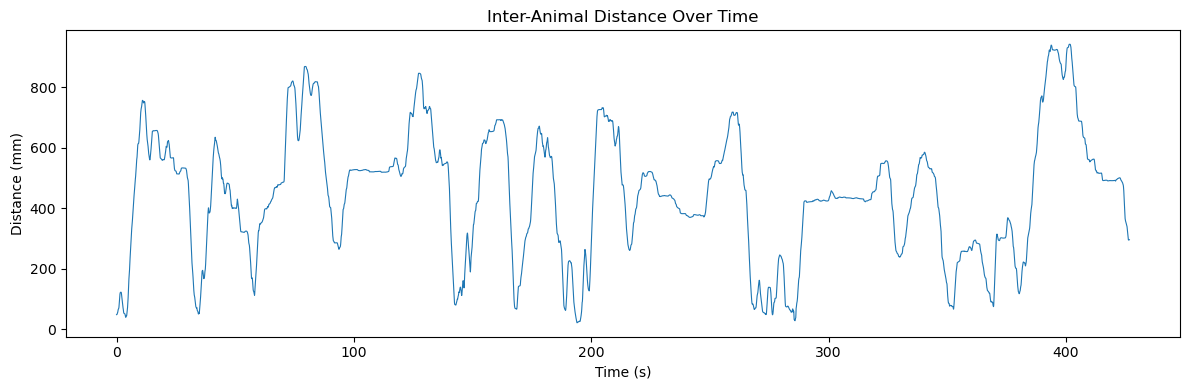

In [6]:
# Compute center-of-mass distance between animals
distance_df = compute_com_distance(
    merged,
    p1="com1",
    p2="com2",
    smooth_window=3,
    dist_smooth_window=3,  # ADD THIS LINE
    return_components=True
)

print(f"Distance statistics:")
print(f"  Mean: {distance_df['dist_mm'].mean():.1f} mm")
print(f"  Min: {distance_df['dist_mm'].min():.1f} mm")
print(f"  Max: {distance_df['dist_mm'].max():.1f} mm")

# Add distance columns to merged DataFrame
merged['dist_mm'] = distance_df['dist_mm']
# Compute dD_dt manually
t_sec = merged.index.to_numpy() / 1000.0  # Convert ms to seconds
merged['dD_dt'] = np.gradient(merged['dist_mm'], t_sec)

# Plot distance over time
plt.figure(figsize=(12, 4))
plt.plot(merged.index / 1000, merged['dist_mm'], lw=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')
plt.title('Inter-Animal Distance Over Time')
plt.tight_layout()
plt.show()


---
## 3. Motion Analysis

Compute velocities and speeds for both animals.


In [7]:
# Compute motion characteristics for both animals
motion1 = compute_motion_direction(merged, prefix="com1", time_col="timestamp_ms_mini")
motion2 = compute_motion_direction(merged, prefix="com2", time_col="timestamp_ms_mini")

# Add to merged DataFrame
for col in motion1.columns:
    merged[col] = motion1[col]
for col in motion2.columns:
    merged[col] = motion2[col]

print(f"Animal 1 mean speed: {motion1['com1_speed'].mean():.2f} mm/s")
print(f"Animal 2 mean speed: {motion2['com2_speed'].mean():.2f} mm/s")


Animal 1 mean speed: 1.72 mm/s
Animal 2 mean speed: 0.94 mm/s


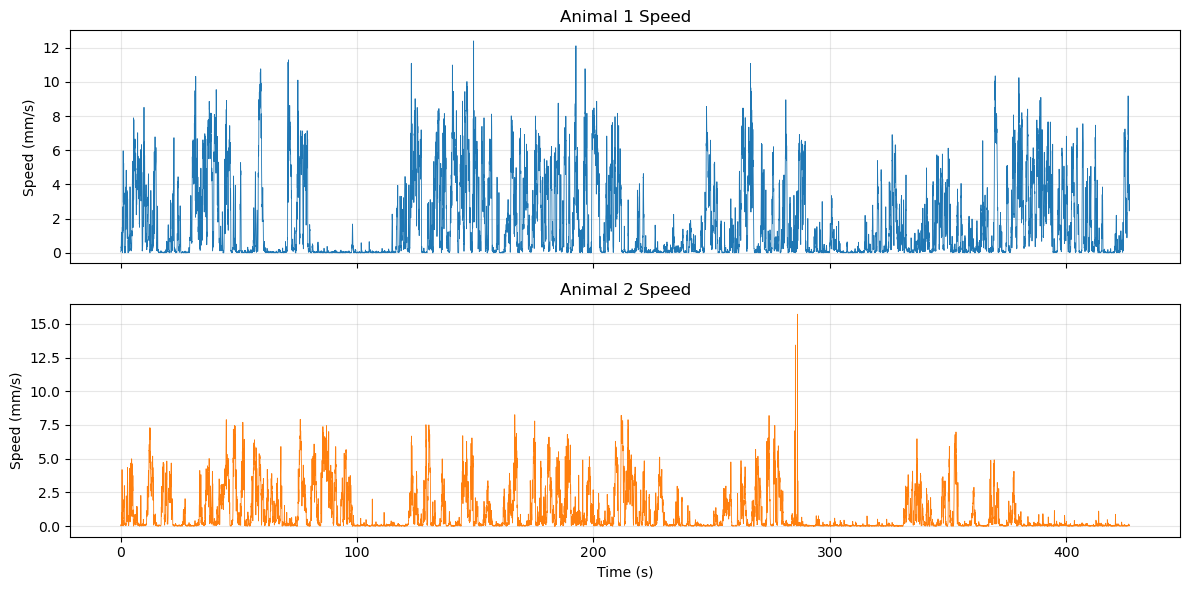

In [8]:
# Plot speed comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

t = merged.index / 1000  # Convert to seconds

ax1.plot(t, motion1['com1_speed'], lw=0.6, label='Animal 1')
ax1.set_ylabel('Speed (mm/s)')
ax1.set_title('Animal 1 Speed')
ax1.grid(alpha=0.3)

ax2.plot(t, motion2['com2_speed'], lw=0.6, label='Animal 2', color='C1')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Speed (mm/s)')
ax2.set_title('Animal 2 Speed')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---
## 4. Detect Approach Success Events

Identify approach→contact sequences where animals move toward each other and achieve contact.

The `find_approach_success()` function detects continuous segments where:
- Distance is decreasing (closing phase)
- Contact is achieved (distance drops below threshold)
- Minimum duration requirements are met


In [9]:
# Create frames DataFrame with required columns
frames = pd.DataFrame({
    'dist_mm': merged['dist_mm'],
    'dD_dt': merged['dD_dt']
}, index=merged.index)

# Detect approach success events
mask, events = find_approach_success(
    frames,
    contact_mm=50.0,      # "touch" threshold
    dD_dt_thresh=0.0,     # distance not increasing
    min_len=10,           # min frames from start to contact
    min_drop_mm=10.0      # require at least 10mm drop
)

print("Approach Success Detection Summary")
print("="*50)
print(f"Total approach success events: {len(events)}")
print(f"Total frames with approach behavior: {mask.sum()}")
print(f"\nFirst 5 events:")
for i, evt in enumerate(events[:5], 1):
    print(f"  Event {i}: frames {evt['start_idx']}-{evt['contact_idx']}, "
          f"drop {evt['drop_mm']:.1f}mm over {evt['duration_frames']} frames")


Approach Success Detection Summary
Total approach success events: 3
Total frames with approach behavior: 141

First 5 events:
  Event 1: frames 56-106, drop 72.7mm over 51 frames
  Event 2: frames 5700-5753, drop 170.7mm over 54 frames
  Event 3: frames 8187-8222, drop 88.5mm over 36 frames


---
## 5. Visualize Events in 3D

Display detected events as 3D skeletal poses in a grid layout.


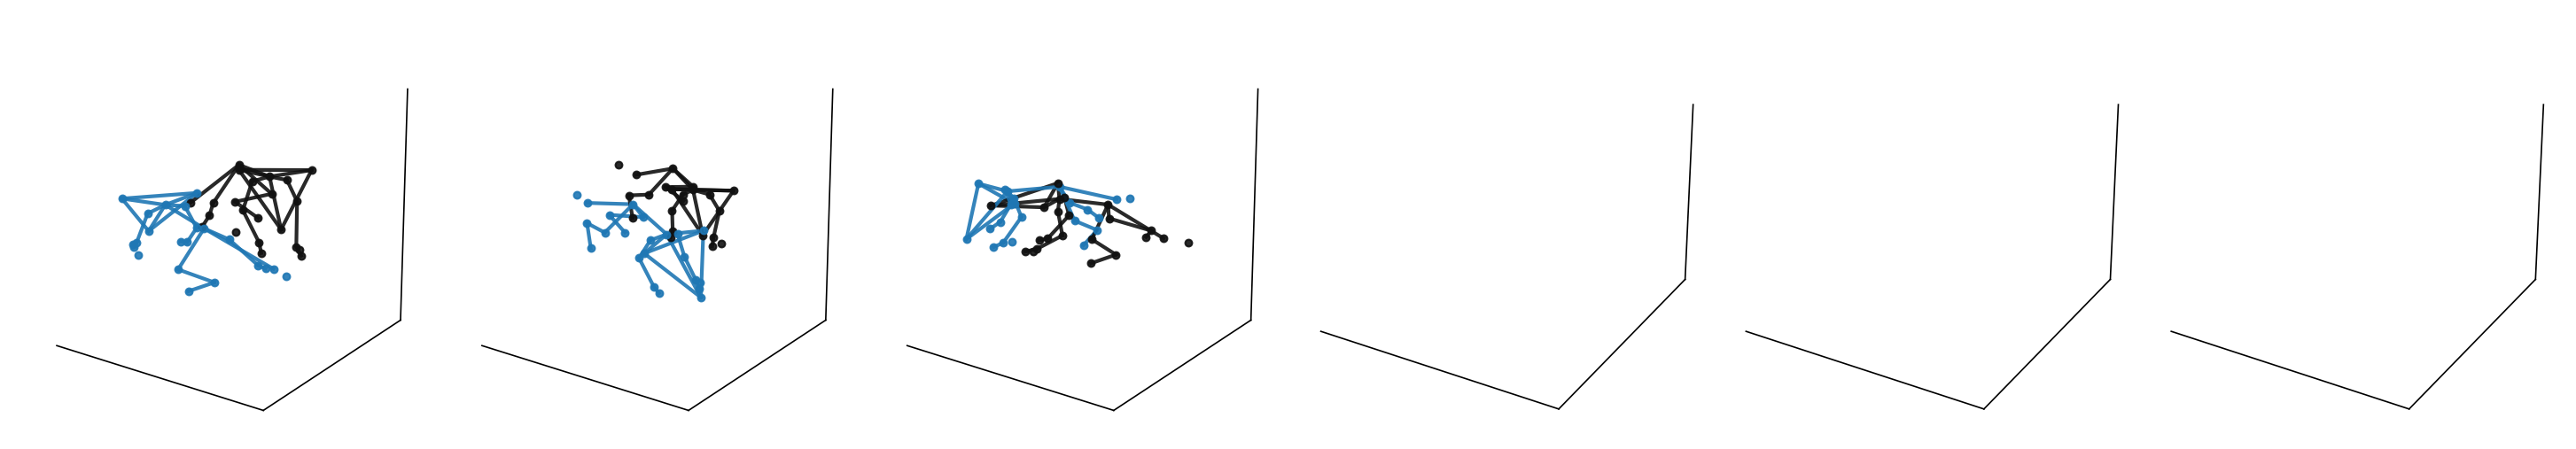

In [10]:
# 1. Create frames DataFrame with required columns
frames = pd.DataFrame({
    'dist_mm': merged['dist_mm'],
    'dD_dt': merged['dD_dt']
}, index=merged.index)

# 2. Detect events
mask, events = find_approach_success(
    frames,
    contact_mm=50.0,
    dD_dt_thresh=0.0,
    min_len=10,
    min_drop_mm=10.0
)

# 3. Map frame indices to timestamps  
event_frame_indices = [evt['contact_idx'] for evt in events[:12]]
event_timestamps = frames.index[event_frame_indices].tolist()

# 4. Import connectivity
from utlis import connectivity
COLOR = connectivity.COLOR_DICT["mouse20"]
CONNECTIVITY = connectivity.CONNECTIVITY_DICT["mouse20"]

# 5. Plot
plot_incidents_3d_grid(
    merged,
    event_timestamps,
    COLOR,
    CONNECTIVITY,
    animal1="a1",
    animal2="a2",
    ncols=6,
    zoom_mode="local",
    a1_color="#111111",
    a2_color="#1f77b4",
    dpi=150
)

---
## 6. Neural Activity & Distance Overview

Create a combined visualization of clustered neural activity and inter-animal distance.


/home/lq53/mir_repos/BBOP/random_tests/25Sep_posters/utlis_version/utlis_version2/keypoint_3d_analysis.py:1795: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


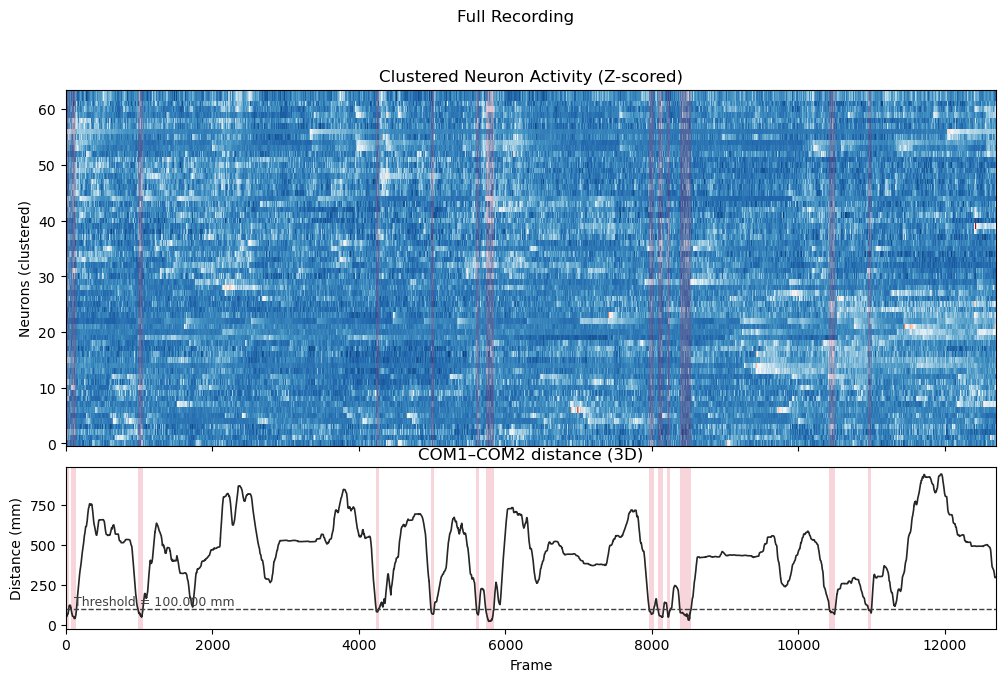

In [11]:
# Plot neural activity heatmap with distance
plot_ca_heatmap_and_distance(
    merged,
    variance_drop_pct=5.0,
    downsample_heatmap=2,
    cmap="RdBu_r",
    distance_smooth_window=1,
    title_prefix="Full Recording",
    save=False
)


---
## 7. Comprehensive Per-Event Analysis

Generate detailed multi-panel visualizations for each detected event.

This creates 4 figure types per event:
1. **Main Stack (5 panels):** Neural activity, COM distance, vertical separations
2. **Egocentric Maps:** Bearing × Elevation heatmaps
3. **Head Pitch:** Pitch angles over time
4. **Head Yaw:** Yaw angles over time


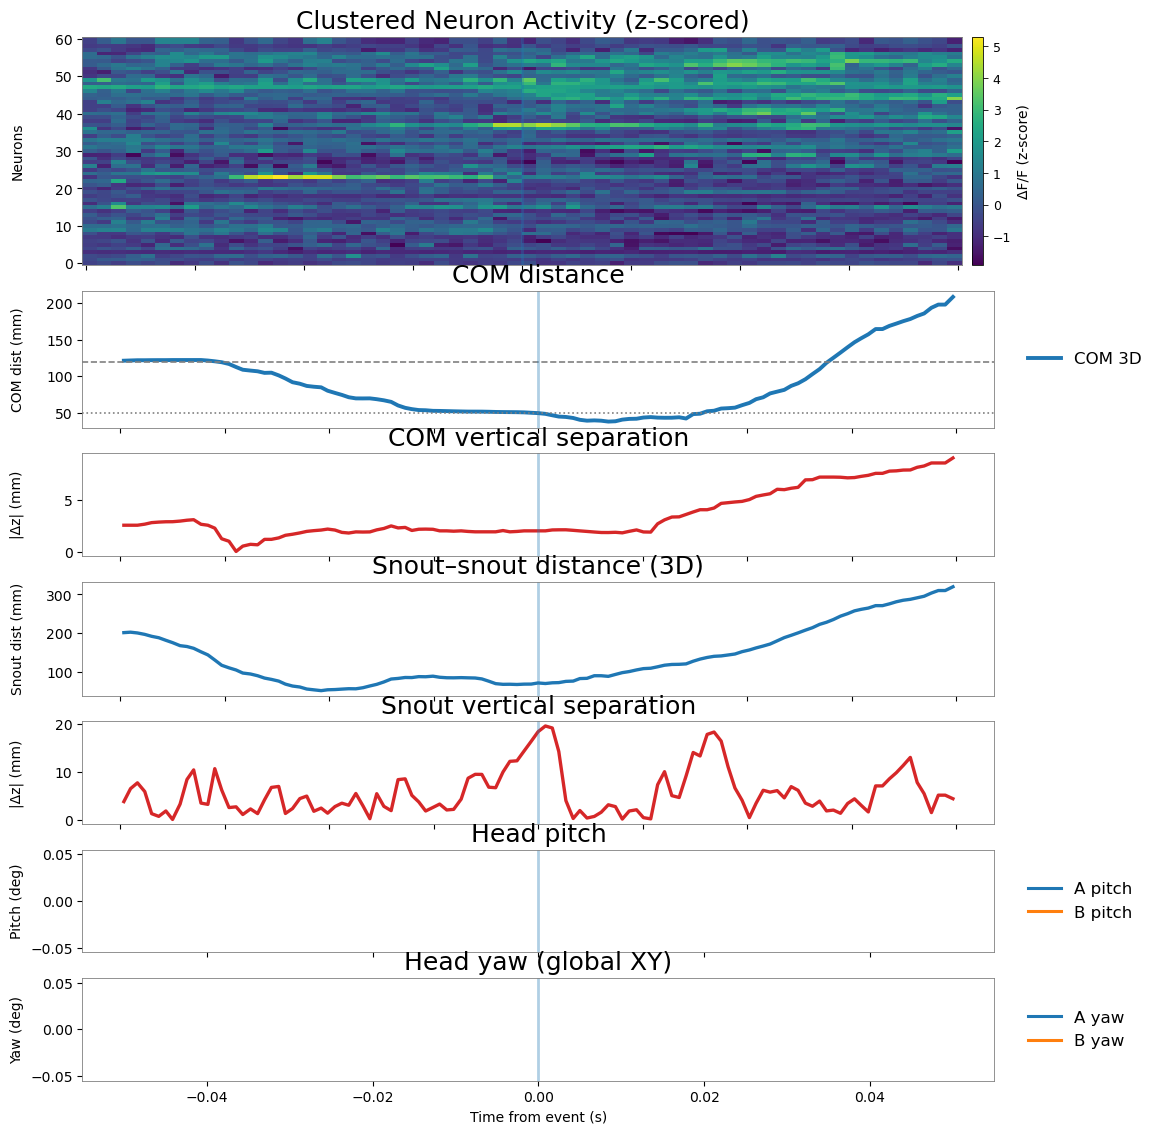

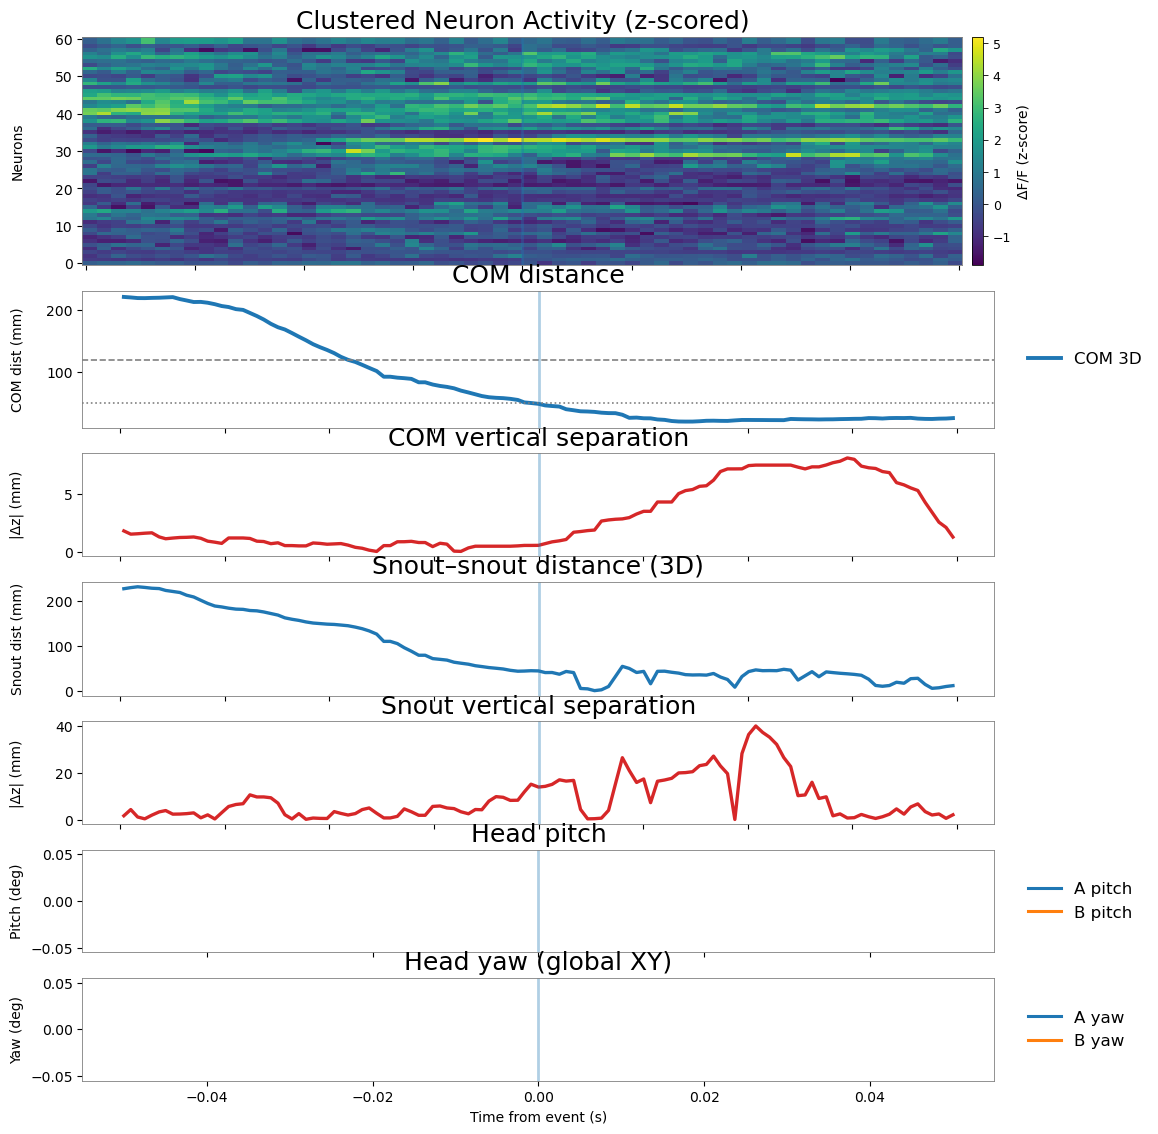

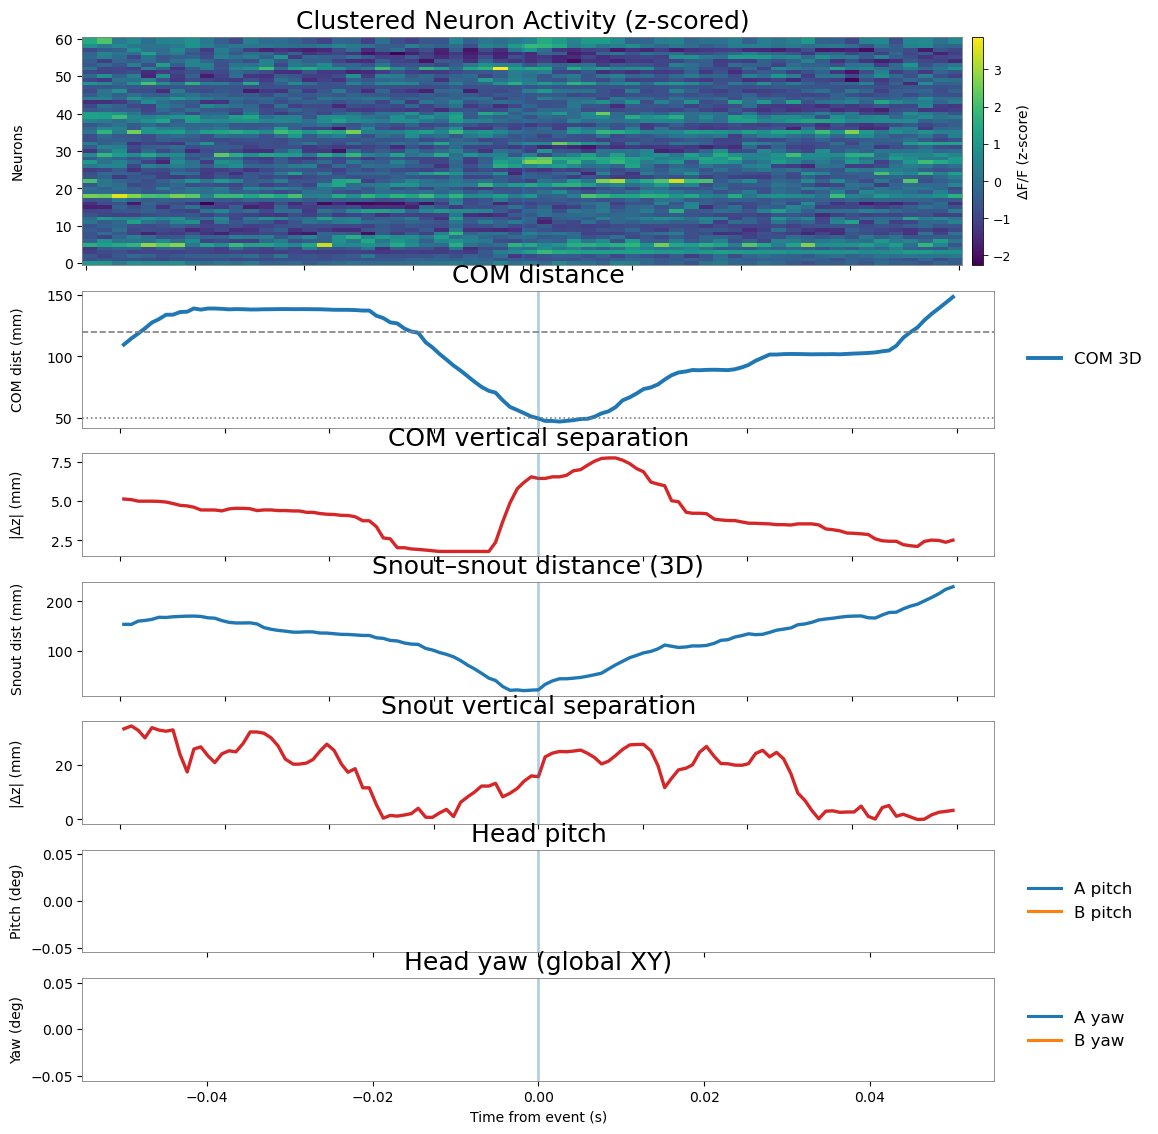

In [12]:
# Analyze first few events in detail
plot_incident_windows_newset(
    merged,
    frames,
    mask,
    pre_s=2.0,
    post_s=2.0,
    variance_drop_pct=10,
    heatmap_downsample=2,
    title_prefix="Mouse Social Interaction",
    save=False,
    out_dir="event_analysis"
)


---
## 8. Summary Statistics

Compile key metrics from the analysis.


In [13]:
# Compile summary statistics
summary = {
    'Total Frames': len(merged),
    'Recording Duration (s)': (merged.index[-1] - merged.index[0]) / 1000,
    'Approach Success Events': len(events),
    'Frames in Events': mask.sum(),
    'Mean Event Duration (frames)': np.mean([e['duration_frames'] for e in events]),
    'Mean Distance Drop (mm)': np.mean([e['drop_mm'] for e in events]),
    'Mean Inter-Animal Distance (mm)': merged['dist_mm'].mean(),
    'Min Distance Achieved (mm)': merged['dist_mm'].min(),
}

print("\nAnalysis Summary")
print("="*50)
for key, val in summary.items():
    if isinstance(val, float):
        print(f"{key}: {val:.2f}")
    else:
        print(f"{key}: {val}")



Analysis Summary
Total Frames: 12700
Recording Duration (s): 426.78
Approach Success Events: 3
Frames in Events: 141
Mean Event Duration (frames): 47.00
Mean Distance Drop (mm): 110.61
Mean Inter-Animal Distance (mm): 445.05
Min Distance Achieved (mm): 21.09


---

## Next Steps

- Adjust detection thresholds based on your data
- Export events for further analysis
- Generate publication-quality figures with `save=True`
- Use `visualize_frames_allcams()` for multi-camera validation

For more details on each function, see the module docstrings in `keypoint_3d_analysis.py`.
